Nour Mansour and Juan Estrella

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

Part 1: Data Collection

Step 1: Get the tsv data

In [2]:
# Data is saved in the same folder as the project. Then read data from tsv file
data = pd.read_csv("train-balanced-sarcasm.csv")

Part 2: Data Processing

Step 1: Columns required: Label, Comments, subreddit, parent comment

Step 2: Create a Dataframe containing an even amount of sarcastic and non sarcastic 
comments, amount of data is 505413 each. 

In [3]:
# Reset the indices after rows with NA values are dropped
data.dropna(inplace=True)
data.drop(['author', 'score', 'ups', 'downs', 'date', 'created_utc', 'subreddit', 'parent_comment'], axis = 1, inplace = True)
data.reset_index(inplace = True)
data.drop(['index'], axis = 1, inplace = True)
data.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [4]:
#data.groupby('label').describe()

We really wanted to use the entire dataset, unfortunately our laptops weren't strong enough to perform the different types of data manipulation and analysis we wanted. 
As a solution, we decided to sample 10% of the dataset each time we ran the program. 10% was actually the largest sample we could get without our Jupyter kernel dying from overflowing Docker's allocated memory resources (we set the memory for Docker to the max value possible given our laptops' specs!). 

In [5]:
# Determine size and replacement values
size = int(len(data)*7.5/100)# sample size
replace = True  # with replacement
# Function used to pick random rows from the dataset
# We used the groupby('label') function to choose equal numbers 
# of sarcastic and non-sarcastic comments
fun = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
chosen_data = data.groupby('label', as_index=False).apply(fun)
chosen_data.head()

label                                            comment
0 11693       0  Well, that'll teach you what neutrality gets you.
  290546      0                                             Sorry!
  734579      0  TIL that someone was able to win a game of mon...
  403934      0                  Go do it outside a school and see
  993220      0                               Im just knocked out.

In [6]:
# Reset the indexes to remove the grouping into 0s and 1s
chosen_data.reset_index(inplace = True)
# Delete the columns that include the names of the indexes created from the groups
chosen_data.drop(['level_0', 'level_1'], inplace = True, axis = 1)
chosen_data.head()

,label,comment
0,0,"Well, that'll teach you what neutrality gets you."
1,0,Sorry!
2,0,TIL that someone was able to win a game of mon...
3,0,Go do it outside a school and see
4,0,Im just knocked out.


In [7]:
chosen_data.tail()

,label,comment
151609,1,"Yes, but just imagine how much it would cost t..."
151610,1,At level 6 Diana's ult isn't THAT much lower r...
151611,1,It only applies to females.
151612,1,your forgot the
151613,1,Future Trunks comes back in time after having ...


Part 3: Exploratory Analysis & Data Visualization

We made sure we got equal number of sarcastic and non-sarcastic comments. From the following histogram, we notice we got 50,000 comments from each group.

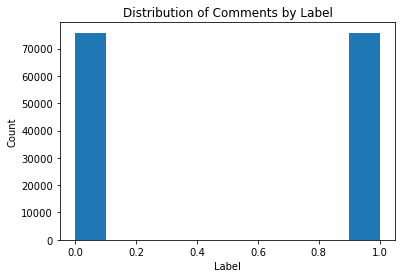

In [8]:
# Explore distribution of the data by label (0 -> non-sarcastic, 1 -> sarcastic)
plt.hist(chosen_data.label)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Comments by Label')
plt.show()

In [9]:
# Explore distribution of comments by label 
chosen_data.groupby('label').describe()

comment                            
        count unique             top freq
label                                    
0       75807  68537         Thanks!   63
1       75807  68878  You forgot the  225

In [10]:
#Import NLTK library
!pip install nltk

In [11]:
import nltk

In [13]:
# nltk.download("all")

In [14]:
from nltk.corpus import stopwords #Use this to get rid of meaningless words like "the, and, a"
from nltk.tokenize import word_tokenize #Split by word
from nltk.tokenize import sent_tokenize #Split by sentence

In [15]:
#Make sure all the comment column is str data type
chosen_data['comment'] = chosen_data['comment'].astype(str)
chosen_data['comment'] = chosen_data['comment'].astype(str)

#non_sarcastic = required_data.loc[required_data['label'] == 0]
#sarcastic = required_data.loc[required_data['label'] == 1]

#drop rows with na values on the comment column
#non_sarcastic['comment'].dropna(inplace=True)
#sarcastic['comment'].dropna(inplace=True)

#Make sure all the comment column is str data type
#non_sarcastic['comment'] = non_sarcastic['comment'].astype(str)
#sarcastic['comment'] = sarcastic['comment'].astype(str)
#print(len(non_sarcastic), len(sarcastic))

In [16]:
# Split the comments into words
chosen_data['comment'] = chosen_data['comment'].apply(word_tokenize)
# Apply Parts of Speech tagging on the words
chosen_data['POS_tag'] = chosen_data['comment'].apply(nltk.pos_tag)
chosen_data.head()

,label,comment,POS_tag
0,0,"[Well, ,, that, 'll, teach, you, what, neutral...","[(Well, RB), (,, ,), (that, DT), ('ll, MD), (t..."
1,0,"[Sorry, !]","[(Sorry, NN), (!, .)]"
2,0,"[TIL, that, someone, was, able, to, win, a, ga...","[(TIL, NN), (that, IN), (someone, NN), (was, V..."
3,0,"[Go, do, it, outside, a, school, and, see]","[(Go, VB), (do, VBP), (it, PRP), (outside, IN)..."
4,0,"[Im, just, knocked, out, .]","[(Im, NNP), (just, RB), (knocked, VBD), (out, ..."


In [17]:
# Apply stemming on the tokenized comments to get the roots of the words
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

chosen_data['stem'] = chosen_data['comment'].apply(lambda x: [stemmer.stem(y) for y in x])
chosen_data.head()

,label,comment,POS_tag,stem
0,0,"[Well, ,, that, 'll, teach, you, what, neutral...","[(Well, RB), (,, ,), (that, DT), ('ll, MD), (t...","[well, ,, that, ll, teach, you, what, neutral,..."
1,0,"[Sorry, !]","[(Sorry, NN), (!, .)]","[sorri, !]"
2,0,"[TIL, that, someone, was, able, to, win, a, ga...","[(TIL, NN), (that, IN), (someone, NN), (was, V...","[til, that, someon, was, abl, to, win, a, game..."
3,0,"[Go, do, it, outside, a, school, and, see]","[(Go, VB), (do, VBP), (it, PRP), (outside, IN)...","[go, do, it, outsid, a, school, and, see]"
4,0,"[Im, just, knocked, out, .]","[(Im, NNP), (just, RB), (knocked, VBD), (out, ...","[im, just, knock, out, .]"


In [38]:
# Not sure if we'll need to lemmatize the words yet

#from nltk.stem import WordNetLemmatizer
#data['lemma'] = data['tokenized_by_word'].apply(WordNetLemmatizer)
# df14.append(df24.append(df34.append(df44)))
# df14.tail()

### Predicting Sarcasm

We were interested in trying different models for predicting a sarcastic comment.
To determine the features and labels for the analysis, we decided to look at the comment itself as a feature and use the given sarcastic vs non-sarcastic classification as our label.

Various articles and studies looked at sarcasm and attempted to predict using different features. For instance, an online tutorial only looked at TF-IDF as a feature, so we decided we wanted to experiment with that and see if we would get anything remotely close to their findings. Worth noting, however, that they looked at tweets with the #sarcasm tag, their dataset was significantly smaller than ours (N= ), and their training vs test data split was slightly unusual (training = 95%, test = 5%). 

To create a more reliable model, we decided to split our data into the more common 80-20 split for training and test subsets respectively. We also chose three main models to compare, acknowledging that some of them might fare slightly more poorly compared to the others. We also assumed TF-IDF vectorization of the comments alone would not be a good predictor for whether a comment is sarcastic or not. 

The three models we picked were:
1. Logistic regression
2. Support Vector Machine
3. Random forest

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [19]:
# Determine the features and labels for the models
features = chosen_data['stem'].apply(lambda x: ' '.join(x))
labels = chosen_data['label']

In [76]:
#features

We vectorized the comments here and used the TF-IDF list as the feature in our model.

In [20]:
# TF-IDF to vectorize the data

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer() # ask about max features
features = list(features)
X = vectorizer.fit_transform(features)

In [21]:
#print(vectorizer.get_feature_names())
print(X.shape)

(151614, 45209)


In [22]:
print(X)
# X.toarray() # it only works if it's an array but why does it become all 0s?
# X

  (0, 43471)	0.2791418201220239
  (0, 39614)	0.17726836590534142
  (0, 23948)	0.3291728364522435
  (0, 39263)	0.47993327011500386
  (0, 44815)	0.34662750611178744
  (0, 43581)	0.2541067793962365
  (0, 27735)	0.5495512287536406
  (0, 16895)	0.25541658977810305
  (1, 37131)	1.0
  (2, 39614)	0.16188843396595326
  (2, 40001)	0.39305733655968983
  (2, 37043)	0.31509981472321025
  (2, 43225)	0.22068896392635715
  (2, 2135)	0.3768052536256888
  (2, 40167)	0.1487215256595992
  (2, 43879)	0.3495653799675294
  (2, 16440)	0.2766372193936578
  (2, 28698)	0.171211787563474
  (2, 26569)	0.5283641542594906
  (3, 17259)	0.34468955296473075
  (3, 12108)	0.2693570525998392
  (3, 21185)	0.20830029372263653
  (3, 29346)	0.5707448583604866
  (3, 35022)	0.5053419324144087
  (3, 3300)	0.2161025193095052
  :	:
  (151610, 24259)	0.32355504260114853
  (151610, 32707)	0.33470796180240836
  (151610, 41381)	0.35671972701204085
  (151610, 11600)	0.44872713833599426
  (151610, 28053)	0.47739476513789453
  (151611, 4

In [99]:
#print(X)

In [126]:
chosen_data.head()

,label,comment,POS_tag,stem
0,0,"[And, you, mention, hotel, ,, where, is, the, ...","[(And, CC), (you, PRP), (mention, VBP), (hotel...","[and, you, mention, hotel, ,, where, is, the, ..."
1,0,"[It, 's, definitely, F, ), A, &, amp, ;, T]","[(It, PRP), ('s, VBZ), (definitely, RB), (F, N...","[it, 's, definit, f, ), a, &, amp, ;, t]"
2,0,"[We, finally, figured, out, who, Katy, is, !]","[(We, PRP), (finally, RB), (figured, VBD), (ou...","[we, final, figur, out, who, kati, is, !]"
3,0,"[That, sounds, like, a, solution, .]","[(That, DT), (sounds, VBZ), (like, IN), (a, DT...","[that, sound, like, a, solut, .]"
4,0,"[Yeah, ,, rekkles, really, did, so, well, with...","[(Yeah, UH), (,, ,), (rekkles, NNS), (really, ...","[yeah, ,, rekkl, realli, did, so, well, with, ..."


In [23]:
# Split data into Training and Test data chosen_data[['comment', 'POS_tag', 'stem']]

X_train, X_test, y_train, y_test = train_test_split(X, chosen_data.label, test_size=0.2, random_state=0)

In [25]:
# Logistic Regression

log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(X_train, y_train)

In [26]:
# Predict the test values

log_clf.predict(X_test)

array([0, 0, 0, ..., 1, 1, 0])

In [27]:
# Logistic regression score
print(log_clf.score(X_train, y_train))
print(log_clf.score(X_test, y_test))

0.7392881582310311
0.6829469379678792


In [28]:
# SVM model

svm_clf = LinearSVC()

In [29]:
# Training the model

svm_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [30]:
print(svm_clf.score(X_train, y_train))
print(svm_clf.score(X_test, y_test))

0.7922764261157053
0.6805395244533852


In [31]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators = 10)

In [32]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
print(rf_clf.score(X_train, y_train))
print(rf_clf.score(X_test, y_test))

0.9794296361642661
0.6888500478184876


After confirming our suspicions that using TF-IDF on the raw tokenized comments would yield very modest results, we decided to continue exploring how we can fix our models. First, we used chunking to break up the comments into more meaningful noun phrases. 

In [34]:
# Use reg ex to chunk the sentences into noun phrases
np_chunking = "NP: {<DT>?<JJ>*<NN>}"
chunk_parser = nltk.RegexpParser(np_chunking)
chosen_data['noun_phrase_chunk'] = chosen_data['POS_tag'].apply(chunk_parser.parse)

Notice how the chunked sentences column groups the nouns into groups with

In [35]:
chosen_data.iloc[0:10, 2:5:2]

,POS_tag,noun_phrase_chunk
0,"[(Well, RB), (,, ,), (that, DT), ('ll, MD), (t...","[(Well, RB), (,, ,), (that, DT), ('ll, MD), (t..."
1,"[(Sorry, NN), (!, .)]","[[(Sorry, NN)], (!, .)]"
2,"[(TIL, NN), (that, IN), (someone, NN), (was, V...","[[(TIL, NN)], (that, IN), [(someone, NN)], (wa..."
3,"[(Go, VB), (do, VBP), (it, PRP), (outside, IN)...","[(Go, VB), (do, VBP), (it, PRP), (outside, IN)..."
4,"[(Im, NNP), (just, RB), (knocked, VBD), (out, ...","[(Im, NNP), (just, RB), (knocked, VBD), (out, ..."
5,"[(4890, CD), (35, CD), (shipped, VBN), (., .)]","[(4890, CD), (35, CD), (shipped, VBN), (., .)]"
6,"[(This, DT), (needs, VBZ), (to, TO), (be, VB),...","[(This, DT), (needs, VBZ), (to, TO), (be, VB),..."
7,"[(Thinking, VBG), (the, DT), (judge, NN), (is,...","[(Thinking, VBG), [(the, DT), (judge, NN)], (i..."
8,"[(The, DT), (end, NN), (is, VBZ), (always, RB)...","[[(The, DT), (end, NN)], (is, VBZ), (always, R..."
9,"[(Did, NNP), (not, RB), (expect, VB), (to, TO)...","[(Did, NNP), (not, RB), (expect, VB), (to, TO)..."


In [36]:
chosen_data.tail()

,label,comment,POS_tag,stem,noun_phrase_chunk
151609,1,"[Yes, ,, but, just, imagine, how, much, it, wo...","[(Yes, UH), (,, ,), (but, CC), (just, RB), (im...","[yes, ,, but, just, imagin, how, much, it, wou...","[(Yes, UH), (,, ,), (but, CC), (just, RB), (im..."
151610,1,"[At, level, 6, Diana, 's, ult, is, n't, THAT, ...","[(At, IN), (level, NN), (6, CD), (Diana, NNP),...","[at, level, 6, diana, 's, ult, is, n't, that, ...","[(At, IN), [(level, NN)], (6, CD), (Diana, NNP..."
151611,1,"[It, only, applies, to, females, .]","[(It, PRP), (only, RB), (applies, VBZ), (to, T...","[it, onli, appli, to, femal, .]","[(It, PRP), (only, RB), (applies, VBZ), (to, T..."
151612,1,"[your, forgot, the]","[(your, PRP$), (forgot, VBD), (the, DT)]","[your, forgot, the]","[(your, PRP$), (forgot, VBD), (the, DT)]"
151613,1,"[Future, Trunks, comes, back, in, time, after,...","[(Future, JJ), (Trunks, NNP), (comes, VBZ), (b...","[futur, trunk, come, back, in, time, after, ha...","[(Future, JJ), (Trunks, NNP), (comes, VBZ), (b..."


In [37]:
joined_tag = []
for index, row in chosen_data.iterrows():
    joined_tag.append(' '.join([word + "_" + pos for word, pos in row['POS_tag']]))
chosen_data['joined_POS_tag'] = joined_tag.copy()

In [38]:
chosen_data.head()

,label,comment,POS_tag,stem,noun_phrase_chunk,joined_POS_tag
0,0,"[Well, ,, that, 'll, teach, you, what, neutral...","[(Well, RB), (,, ,), (that, DT), ('ll, MD), (t...","[well, ,, that, ll, teach, you, what, neutral,...","[(Well, RB), (,, ,), (that, DT), ('ll, MD), (t...","Well_RB ,_, that_DT 'll_MD teach_VB you_PRP wh..."
1,0,"[Sorry, !]","[(Sorry, NN), (!, .)]","[sorri, !]","[[(Sorry, NN)], (!, .)]",Sorry_NN !_.
2,0,"[TIL, that, someone, was, able, to, win, a, ga...","[(TIL, NN), (that, IN), (someone, NN), (was, V...","[til, that, someon, was, abl, to, win, a, game...","[[(TIL, NN)], (that, IN), [(someone, NN)], (wa...",TIL_NN that_IN someone_NN was_VBD able_JJ to_T...
3,0,"[Go, do, it, outside, a, school, and, see]","[(Go, VB), (do, VBP), (it, PRP), (outside, IN)...","[go, do, it, outsid, a, school, and, see]","[(Go, VB), (do, VBP), (it, PRP), (outside, IN)...",Go_VB do_VBP it_PRP outside_IN a_DT school_NN ...
4,0,"[Im, just, knocked, out, .]","[(Im, NNP), (just, RB), (knocked, VBD), (out, ...","[im, just, knock, out, .]","[(Im, NNP), (just, RB), (knocked, VBD), (out, ...",Im_NNP just_RB knocked_VBD out_RP ._.


In [39]:
features2 = chosen_data['joined_POS_tag']
#features2

In [40]:
features2 = list(features2)
X2 = vectorizer.fit_transform(features2)

In [41]:
X2

<151614x95068 sparse matrix of type '<class 'numpy.float64'>'
	with 1561732 stored elements in Compressed Sparse Row format>

In [43]:
#print(X2)

In [44]:
# Split data into Training and Test data chosen_data[['comment', 'POS_tag', 'stem']]

X_train, X_test, y_train, y_test = train_test_split(X2, chosen_data.label, test_size=0.2, random_state=0)

In [46]:
# Logistic Regression

log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(X_train, y_train)

In [47]:
# Logistic regression score
print(log_clf.score(X_train, y_train))
print(log_clf.score(X_test, y_test))

0.7819541433412207
0.6916861788081654


In [48]:
# SVM model
svm_clf = LinearSVC()

# Training the model
svm_clf.fit(X_train, y_train)

print(svm_clf.score(X_train, y_train))
print(svm_clf.score(X_test, y_test))

0.8720515124782547
0.6900702437093955


In [49]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators = 10)

rf_clf.fit(X_train, y_train)

print(rf_clf.score(X_train, y_train))
print(rf_clf.score(X_test, y_test))

0.980196387201029
0.6772746759885235
